# Impurity Model for nEXO

This analysis focuses on studying the impact of electronegative impurities in certain environments. We will go through a series of calculations and visual representations to understand this phenomenon better. See Ako Jamil's thesis chapter 4.2 for reference.

The class `Outgassing_setup` will load the necessary information from `library.json` by defining 4 key parameters: The name of the system (`Setup`), the material inside that setup that is outgassing (`Material`), the gas species that is dissolved inside the material (`Solute`) and the dimension of that piece of material (`Version`).

Data units and infos are written in the ReadMe document.

In [1]:
# Load packages
import elec_neg_functions as enf
import matplotlib.pyplot as plt

# Modelling outgassing of impurities

**For models that are temperature dependant (only impurities & plastics flow rates for now):** When multiple timestamps are defined, each timestamp will correspond to a specific set of temperatures, and the number of temperatures specified should match the number of timestamps. However, if there is only one timestamp defined, you have the flexibility to include as many temperatures as needed, and all of these temperatures will be plotted on the single timestamp.

For now `get_flow_rate_vs_time` needs `get_impurities_vs_time` to be runned before, to be able to get initial impurities for each timestamps.

### Desorption from Stainless Steel

Stainless steel desorption evolution with pumping time can be calculated using an empirical law, given the outgassing flow rate from an unbaked stainless steel surface after an initial pumping time.

In [2]:
# Defining the system
Exo_200_steel = enf.Outgassing_setup(
    setup="EXO-200",
    material="Stainless-Steel",
    solute="Oxygen",
    version="EXO-Stainless-Steel",
)

# Set time regions
steel_timestamps = enf.get_time_stamps(
    points=[1e-1, 1e4], spacing=1, time_scale="Hours"
)

print(Exo_200_steel)  # Using the method __str__

# Calculate outgassing rate, with initial_pumped_time given in seconds
steel_flow_rates = Exo_200_steel.get_steel_flow_rate_vs_pumping_time(
    time=steel_timestamps, unbaked_flow_rate=1e-8, initial_pumped_time=2600
)

name: EXO-200
material: Stainless-Steel
solute: Oxygen
version: EXO-Stainless-Steel
area: 3000.0
abundance: 0.21
molar_mass: 32
xe_mass: 200000


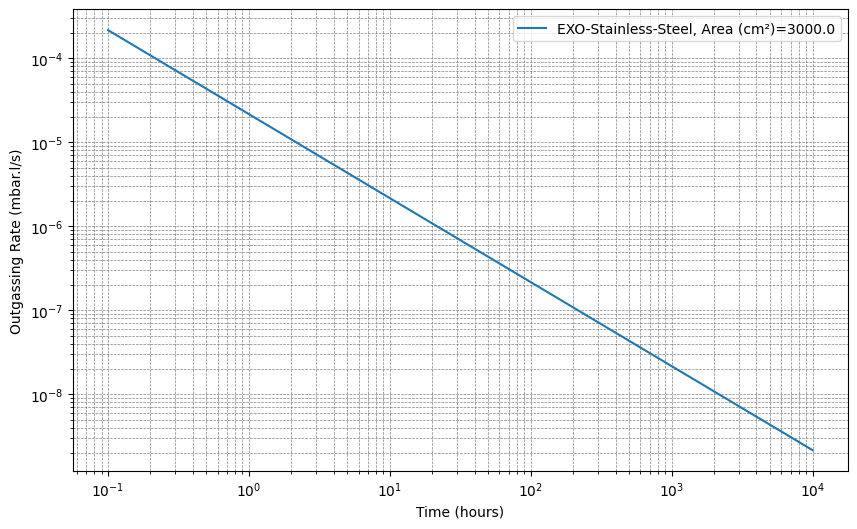

In [3]:
# Configuring the outgassing rate plot
plt.figure(figsize=(10, 6))
# plt.title(f'Outgassing rate of mono-layers of impurities on stainless steel walls as a function of pumping time in EXO-200')
plt.xlabel("Time (hours)")
plt.ylabel("Outgassing Rate (mbar.l/s)")
plt.yscale("log")
plt.xscale("log")
plt.grid(which="both", linestyle="--", linewidth="0.5", color="gray")

# Convert time from seconds to hours for the plot
time_in_hours = [t / 3600 for t in steel_timestamps[0]]

label = f"{Exo_200_steel.version}, Area (cm²)={Exo_200_steel.area}"
plt.plot(time_in_hours, steel_flow_rates[0], label=label)

plt.legend()
plt.show()

### Outgassing from plastics

Also using the class `Outgassing_setup`, but this time calling methods solving the diffusion equation to get the number of impurities, and Fick's 1st law to get the outgassing rates.

In [4]:
# Defining the system
Nexo_kapton = enf.Outgassing_setup(
    setup="nEXO", material="Kapton", solute="Oxygen", version="nEXO-Kapton"
)

# Define or change other parameters of the system
Nexo_kapton.temperatures = [293, 164]
Nexo_kapton.activation_energy = 0.47

# Set time regions for the above defined temperature values
kapton_timestamps = enf.get_time_stamps(
    points=[1e-1, 1e2], spacing=0.1, time_scale="Seconds"
)

print(Nexo_kapton)

name: nEXO
material: Kapton
solute: Oxygen
version: nEXO-Kapton
temperatures: [293, 164]
diffusion: 3.14e-07
solubility: 0.22
activation_energy: 0.47
volume: 0.0625
area: 12500.0
thickness: 0.005
abundance: 0.21
molar_mass: 32
xe_mass: 5000000
field_factor: 0.3
comment: Field Factor value at EXO-200 drift field


Calculate impurities and outgassing by first getting the diffusion constants for the above defined temperatures using the Arrhenius equation, then getting the initial number of impurities from model parameters (in total number of impurities `'#'`, or ratio between number of impurities and number of xenon atoms in the setup `'ppm','ppb','ppt'` or total mass of impurities `'Mass'`).

In [5]:
# Calculate diffusion constants and initial impurities.
Nexo_kapton.get_diff_temp()
Nexo_kapton.get_initial_impurities(units="#")

# Calculate the number of impurities & outgassing rates with time.
kapton_impurities = Nexo_kapton.get_impurities_vs_time(time=kapton_timestamps)

kapton_flow_rates = Nexo_kapton.get_flow_rate_vs_time(
    time=kapton_timestamps, impurities=kapton_impurities, units="mBar Liter"
)

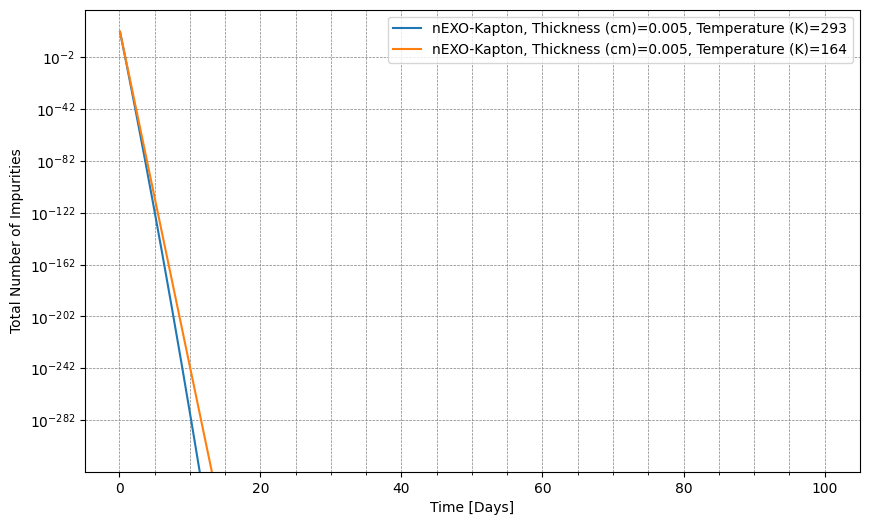

In [6]:
# Configuring the impurities plot
plt.figure(figsize=(10, 6))
plt.xlabel("Time [Days]")
plt.ylabel("Total Number of Impurities")
plt.yscale("log")
plt.grid(which="both", linestyle="--", linewidth=0.5, color="gray")
plt.minorticks_on()

# Iterating through the dataset
for time_data, impurities, temperature in zip(
    (
        kapton_timestamps
        if len(kapton_timestamps) > 1
        else [kapton_timestamps[0]] * len(kapton_impurities)
    ),
    kapton_impurities,
    Nexo_kapton.temperatures,
):
    label = f"{Nexo_kapton.version}, Thickness (cm)={Nexo_kapton.thickness}, Temperature (K)={temperature}"
    plt.plot(time_data, impurities, label=label)

plt.legend()
plt.show()

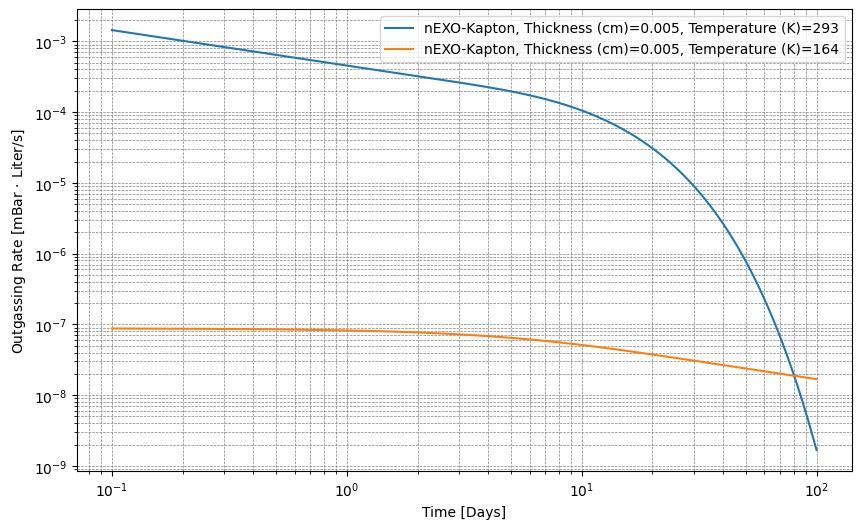

In [7]:
# Configuring the outgassing rate plot
plt.figure(figsize=(10, 6))
plt.xlabel("Time [Days]")
plt.ylabel(r"Outgassing Rate [mBar$\,\cdot\,$Liter/s]")
plt.xscale("log")
plt.yscale("log")
plt.grid(which="both", linestyle="--", linewidth=0.5, color="gray")
plt.minorticks_on()

# Iterating through the dataset
for time_data, flow_rates, temperature in zip(
    (
        kapton_timestamps
        if len(kapton_timestamps) > 1
        else [kapton_timestamps[0]] * len(kapton_flow_rates)
    ),
    kapton_flow_rates,
    Nexo_kapton.temperatures,
):
    label = f"{Nexo_kapton.version}, Thickness (cm)={Nexo_kapton.thickness}, Temperature (K)={temperature}"
    plt.plot(time_data, flow_rates, label=label)

plt.legend()
plt.show()

It is also possible to use automatic plotting by formatting the data correctly.

In [8]:
# Defining the system
Nexo_teflon = enf.Outgassing_setup(
    setup="EXO-200", material="Teflon", solute="Oxygen", version="EXO-Teflon"
)

# Define other parameters and time regions of the system
Nexo_teflon.temperatures = [293, 164]
time_scale = "Days"  # Define the time scale here
teflon_timestamps = enf.get_time_stamps(
    points=[0, 2, 20], spacing=1 / (24 * 60), time_scale=time_scale
)

# Calculate diffusion constants and initial impurities.
Nexo_teflon.get_diff_temp()
Nexo_teflon.get_initial_impurities(units="#")

# Calculate the number of impurities & outgassing rates with time.
teflon_impurities = Nexo_teflon.get_impurities_vs_time(time=teflon_timestamps)
teflon_flow_rates = Nexo_teflon.get_flow_rate_vs_time(
    time=teflon_timestamps, impurities=teflon_impurities, units="mBar Liter"
)

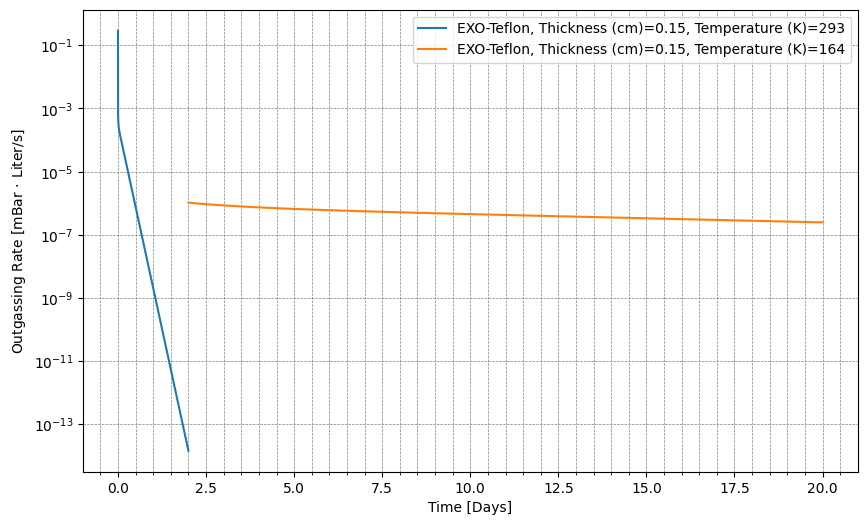

In [9]:
# Automatic plotting
# Preparing data for the function
impurities_data = [
    (
        time_data,
        impurity,
        f"{Nexo_teflon.version}, Thickness (cm)={Nexo_teflon.thickness}, Temperature (K)={temp}",
    )
    for time_data, impurity, temp in zip(
        teflon_timestamps, teflon_impurities, Nexo_teflon.temperatures
    )
]
flow_rates_data = [
    (
        time_data,
        flow_rate,
        f"{Nexo_teflon.version}, Thickness (cm)={Nexo_teflon.thickness}, Temperature (K)={temp}",
    )
    for time_data, flow_rate, temp in zip(
        teflon_timestamps, teflon_flow_rates, Nexo_teflon.temperatures
    )
]

# Plotting outgassing rates
enf.plot_data(
    fig_size=(10, 6),
    x_label=f"Time [{time_scale}]",
    y_label=r"Outgassing Rate [mBar$\,\cdot\,$Liter/s]",
    data_sets=flow_rates_data,
    y_scale="log",
    time_unit=time_scale,
)

It is also possible to run modelling for multiple setups together by creating an instance of the System class for each setup.

In [10]:
# Creating instances for each setup
Ylps_exo_teflon = enf.Outgassing_setup(
    setup="YLXPS", material="Teflon", solute="Oxygen", version="EXO-Teflon"
)
Ylps_stock_teflon = enf.Outgassing_setup(
    setup="YLXPS", material="Teflon", solute="Oxygen", version="Stock-Teflon"
)
Ylps_colombia_teflon = enf.Outgassing_setup(
    setup="YLXPS", material="Teflon", solute="Oxygen", version="Columbia-Teflon"
)

# Combining into one list
Ylps_all_teflon = [Ylps_exo_teflon, Ylps_stock_teflon, Ylps_colombia_teflon]
teflon_impurities = []
teflon_flow_rates = []

for system in Ylps_all_teflon:
    system.temperatures = [295, 340]
    teflon_timestamps = enf.get_time_stamps(
        points=[0, 100, 200], spacing=1, time_scale="Hours"
    )

    system.get_diff_temp()
    system.get_initial_impurities(units="#")
    teflon_impurities.append(system.get_impurities_vs_time(time=teflon_timestamps))
    teflon_flow_rates.append(
        system.get_flow_rate_vs_time(
            teflon_timestamps, impurities=teflon_impurities[-1], units="mBar Liter"
        )
    )

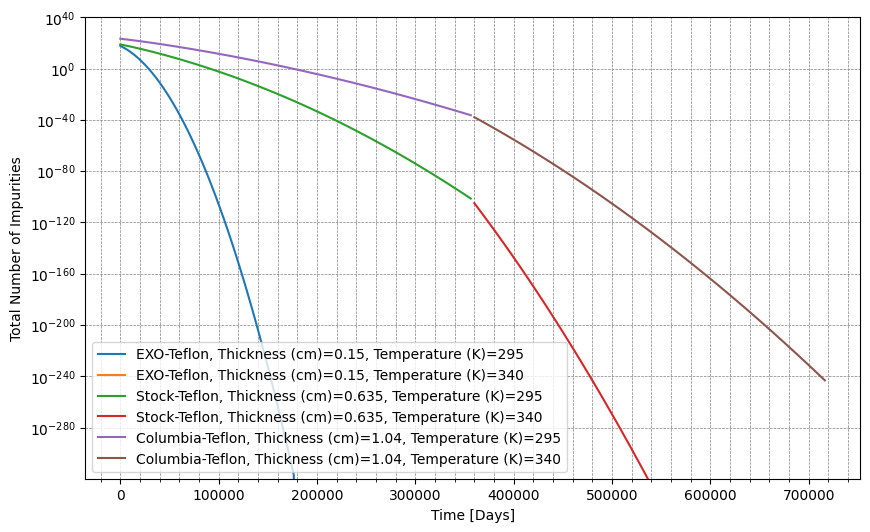

In [11]:
# Configuring the plot
plt.figure(figsize=(10, 6))
plt.xlabel("Time [Days]")
plt.ylabel("Total Number of Impurities")
plt.yscale("log")
plt.grid(which="both", linestyle="--", linewidth=0.5, color="gray")
plt.minorticks_on()

# Plot data
for i, system in enumerate(Ylps_all_teflon):
    # Iterating through the dataset
    for time_data, impurities, temperature in zip(
        (
            teflon_timestamps
            if len(teflon_timestamps) > 1
            else [teflon_timestamps[0]] * len(teflon_impurities[i])
        ),
        teflon_impurities[i],
        system.temperatures,
    ):
        label = f"{system.version}, Thickness (cm)={system.thickness}, Temperature (K)={temperature}"
        plt.plot(time_data, impurities, label=label)

# Set legend and plot
plt.legend()
plt.show()

# Electron lifetime prediction



Predict the electron lifetime evolution with different parameters in a specific system. Use the liquid xenon purification model defined in the presentation "Screening for Electronegative Impurities" by David Moore the 12/07/2022.

In [12]:
# Defining the system
Nexo_electron_lifetime = enf.Outgassing_setup(
    setup="nEXO",
    material="Stainless-Steel",
    solute="Oxygen",
    version="EXO-Stainless-Steel",
)

# Set time regions
lifetime_timestamps = enf.get_time_stamps(
    points=[0, 60], spacing=1 / 24, time_scale="Days"
)

print(Nexo_electron_lifetime)

name: nEXO
material: Stainless-Steel
solute: Oxygen
version: EXO-Stainless-Steel
abundance: 0.21
molar_mass: 32
xe_mass: 5000000
field_factor: 0.3
comment: Field Factor value at EXO-200 drift field


In [13]:
# Loop on a list of different input values, here total out-diffusion rate
out_diffusion_values = [1, 0.1, 0.01]

# Define lists to store results
electron_lifetime_results = []
params_results = []

for out_diffusion_value in out_diffusion_values:
    (
        electron_lifetimes,
        params,
    ) = Nexo_electron_lifetime.get_electron_lifetime_vs_time(
        time=lifetime_timestamps,
        initial_impurities=1,
        circulation_rate=200 / 60,
        purification_efficiency=1,
        out_diffusion=out_diffusion_value,
    )

    electron_lifetime_results.append(electron_lifetimes)
    params_results.append(params)

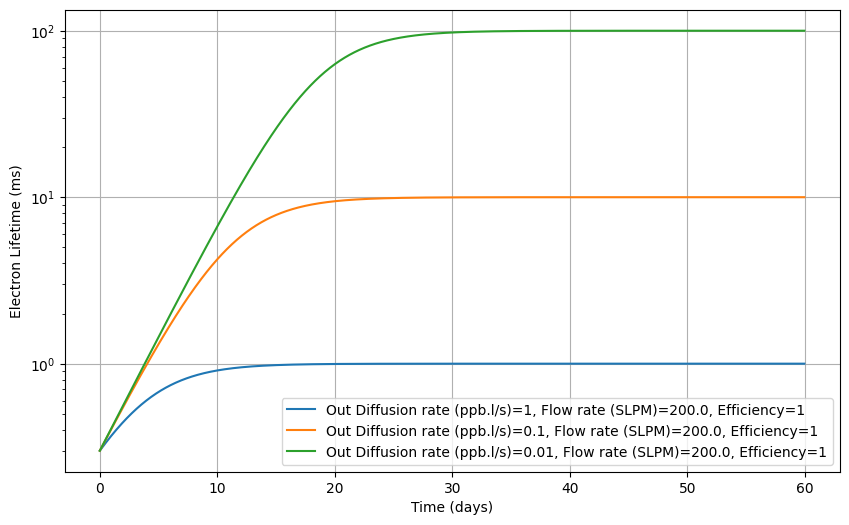

In [14]:
# Configuring the plot
plt.figure(figsize=(10, 6))

plt.xlabel("Time (days)")
plt.ylabel("Electron Lifetime (ms)")
plt.yscale("log")
plt.grid(True)

# Converting time from seconds to days
time_in_days = [t / 86400 for t in lifetime_timestamps[0]]

# Loop through each out_diffusion_value and its corresponding results
for i, out_diffusion_value in enumerate(out_diffusion_values):
    electron_lifetimes = electron_lifetime_results[i]
    params = params_results[i]

    # Plotting, while dividing 'seconds' by the number of seconds in a day to convert to days
    label = f"Out Diffusion rate (ppb.l/s)={params['out_diffusion']}, Flow rate (SLPM)={params['circulation_rate']*60}, Efficiency={params['purification_efficiency']}"
    plt.plot(time_in_days, electron_lifetimes, label=label)

plt.legend()
plt.show()